In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DA0101EN-Coursera/medical_insurance_dataset.csv'

In [4]:
res = requests.get(url)
df = pd.read_csv(url, header = None)

In [5]:
df.columns = ['Age','Gender','BMI','No_of_children','Smoker','Region','Charges']
df.head(10)

,Age,Gender,BMI,No_of_children,Smoker,Region,Charges
0,19,1,27.900,0,1,3,16884.92400
1,18,2,33.770,1,0,4,1725.55230
2,28,2,33.000,3,0,4,4449.46200
3,33,2,22.705,0,0,1,21984.47061
4,32,2,28.880,0,0,1,3866.85520
5,31,1,25.740,0,?,4,3756.62160
6,46,1,33.440,1,0,4,8240.58960
7,37,1,27.740,3,0,1,7281.50560
8,37,2,29.830,2,0,2,6406.41070
9,60,1,25.840,0,0,1,28923.13692


In [6]:
df.replace('?',np.nan,inplace = True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             2768 non-null   object 
 1   Gender          2772 non-null   int64  
 2   BMI             2772 non-null   float64
 3   No_of_children  2772 non-null   int64  
 4   Smoker          2765 non-null   object 
 5   Region          2772 non-null   int64  
 6   Charges         2772 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 151.7+ KB


In [8]:
# Checking for missing values
missing_data = df.isnull()
for i in missing_data.columns:
    print(missing_data[i].value_counts())
    print(' ')

Age
False    2768
True        4
Name: count, dtype: int64
 
Gender
False    2772
Name: count, dtype: int64
 
BMI
False    2772
Name: count, dtype: int64
 
No_of_children
False    2772
Name: count, dtype: int64
 
Smoker
False    2765
True        7
Name: count, dtype: int64
 
Region
False    2772
Name: count, dtype: int64
 
Charges
False    2772
Name: count, dtype: int64
 


In [9]:
df[df.isnull().any(axis = 1)]

,Age,Gender,BMI,No_of_children,Smoker,Region,Charges
5,31,1,25.740,0,NaN,4,3756.62160
28,23,2,17.385,1,NaN,1,2775.19215
72,53,1,28.100,3,NaN,3,11741.72600
122,20,1,28.975,0,NaN,1,2257.47525
176,38,2,27.835,2,NaN,1,6455.86265
234,NaN,2,24.510,2,0,1,6710.19190
242,55,1,26.800,1,NaN,3,35160.13457
324,29,2,27.200,0,NaN,3,2866.09100
1836,NaN,2,29.600,4,0,3,7512.26700
2180,NaN,1,31.920,2,0,1,7209.49180


In [10]:
#converting Age to float as there are string value present and will throw erroe for mean
mean_age = df['Age'].astype('float').mean()
df['Age'].replace(np.nan,mean_age,inplace = True)

# smoker is a categorical attribute, replace with most frequent entry
mode_smoker = df['Smoker'].value_counts().idxmax()
df['Smoker'].replace(np.nan,mode_smoker, inplace = True)

#updating the datatypes
df[['Age','Smoker']] = df[['Age','Smoker']].astype('int')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             2772 non-null   int64  
 1   Gender          2772 non-null   int64  
 2   BMI             2772 non-null   float64
 3   No_of_children  2772 non-null   int64  
 4   Smoker          2772 non-null   int64  
 5   Region          2772 non-null   int64  
 6   Charges         2772 non-null   float64
dtypes: float64(2), int64(5)
memory usage: 151.7 KB


In [11]:
df['Charges'] = round(df['Charges'],2)

In [22]:
df.describe()

,Age,Gender,BMI,No_of_children,Smoker,Region,Charges
count,2772.000000,2772.000000,2772.000000,2772.000000,2772.000000,2772.000000,2772.000000
mean,39.109668,1.507215,30.701349,1.101732,0.203463,2.559885,13261.369957
std,14.081459,0.500038,6.129449,1.214806,0.402647,1.130761,12151.768970
min,18.000000,1.000000,15.960000,0.000000,0.000000,1.000000,1121.870000
25%,26.000000,1.000000,26.220000,0.000000,0.000000,2.000000,4687.800000
50%,39.000000,2.000000,30.447500,1.000000,0.000000,3.000000,9333.015000
75%,51.000000,2.000000,34.770000,2.000000,0.000000,4.000000,16577.780000
max,64.000000,2.000000,53.130000,5.000000,1.000000,4.000000,63770.430000


(0.0, 66902.85800000001)

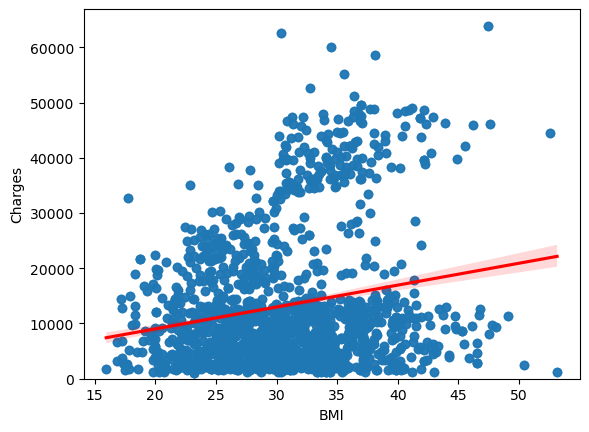

In [12]:
sns.regplot(x = 'BMI',y = 'Charges',data = df,line_kws={'color':'red'})
plt.ylim(0,)

BMI is a significant predictor of increasing costs, but its effect is not linear for all. As a member's BMI increases, so does their expected cost, suggesting that policies should scale premiums based on BMI thresholds

<Axes: xlabel='Smoker', ylabel='Charges'>

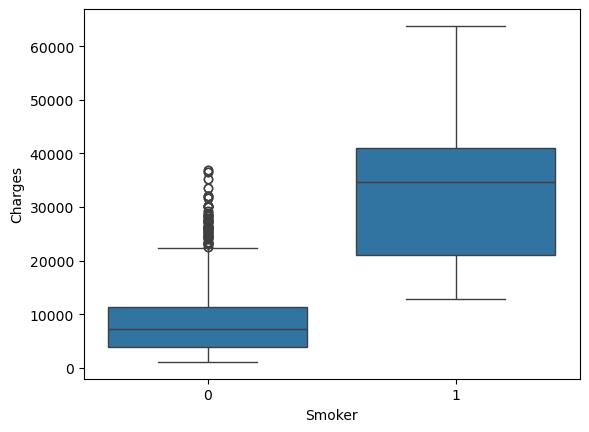

In [13]:
sns.boxplot(x ='Smoker',y = 'Charges',data = df)

**The Impact of Smoking**

Smoking is the single largest controllable risk driver. The data clearly segments our member base, showing that non-smokers are consistently low-cost, while smokers represent a high-risk, high-cost segment. This difference justifies significantly higher premiums for smokers.

<Axes: >

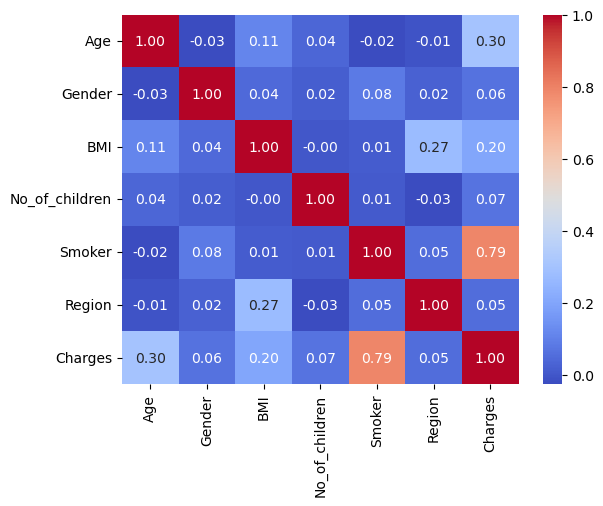

In [14]:
df_corr = df.corr()
sns.heatmap(df_corr,annot = True,fmt = '.2f', cmap = 'coolwarm')

In [15]:
# Implementing Linear Regression for predicting charges with smoker attribute
lm = LinearRegression()
x = df[['Smoker']]
y = df['Charges']
lm.fit(x,y)
score_1 = lm.score(x,y)
#Checking th R squared score
score_1

0.6221791733924185

Smoking alone explains 62% of the variance in charges. This statistic is powerful evidence supporting our current pricing strategy, but it also signals that we must factor in other variables to capture the remaining 38% of cost variation

In [16]:
# Implementing Linear Regression for predicting charges with all the attributes
z = df[['Age','Gender','BMI','No_of_children','Smoker','Region']]
lm.fit(z,y)
score_2 = lm.score(z,y)
score_2

0.7504083820289634

In [17]:
# Creating a training pipeline to create a model that can predict the charges value using all the other attributes of the dataset
Input=[('scale',StandardScaler()), ('polynomial', PolynomialFeatures(include_bias=False)), ('model', LinearRegression())]
pipe = Pipeline(Input)
z = z.astype('float')
pipe.fit(z,y)
ypipe = pipe.predict(z)
print(r2_score(y,ypipe))

0.8452576213500093


In [18]:
# Split the data into training and testing subsets, 20% of the data will be reserved for testing.
x_train,x_test,y_train,y_test = train_test_split(z,y,test_size = 0.2, random_state = 1)

In [19]:
RidgeModel = Ridge(alpha = 0.1)
RidgeModel.fit(x_train,y_train)
yhat = RidgeModel.predict(x_test)
print(r2_score(y_test,yhat))

0.6760807731582406


In [20]:
pr = PolynomialFeatures(degree=2)
x_train_pr = pr.fit_transform(x_train)
x_test_pr = pr.transform(x_test)
RidgeModel.fit(x_train_pr,y_train)
yhat = RidgeModel.predict(x_test_pr)
print(r2_score(y_test,yhat))

0.7835631107608061


**The Value of the Predictive Model**

We can now predict individual member charges with approximately 78% accuracy. This level of predictive power is crucial for three things:
1. Accurate Premium Pricing
2. Financial Forecasting 
3.  Risk Assessment